In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
original_image = cv2.imread('image2.jpg', cv2.IMREAD_GRAYSCALE)

In [2]:
def plot_images(images):
    plt.figure(figsize=(5*len(images), 5))
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i+1)
        plt.title(img[1])
        plt.imshow(img[0], cmap='gray')
        plt.axis('off')

(-0.5, 771.5, 662.5, -0.5)

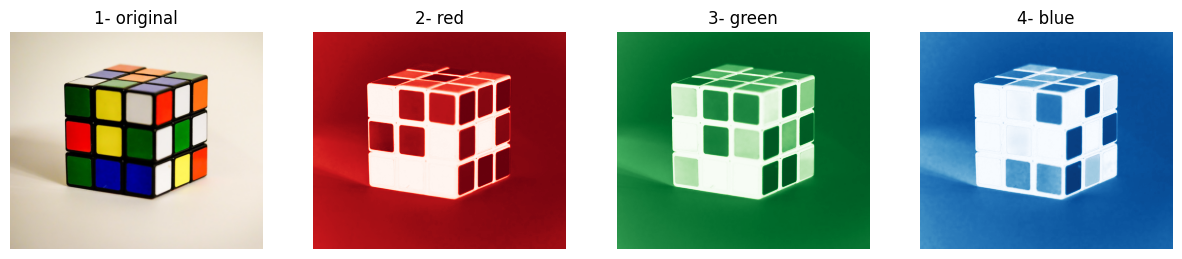

In [3]:
from PIL import Image

image_rgb = Image.open('rubik.jpg')

image_rgb = np.array(image_rgb)
red_channel = image_rgb[:, :, 0]
green_channel = image_rgb[:, :, 1]
blue_channel = image_rgb[:, :, 2]

plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(image_rgb)
plt.title('1- original')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(red_channel, cmap='Reds')
plt.title('2- red')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(green_channel, cmap='Greens')
plt.title('3- green')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(blue_channel, cmap='Blues')
plt.title('4- blue')
plt.axis('off')

#**Log Transformation**

s = c . log(1 + r)


In [4]:
def log_filter(image):
    log_image = np.log1p(image)
    log_image = (255 * log_image / np.max(log_image)).astype(np.uint8)
    return log_image


def inverse_log_filter(image):
    inverse_log_image = np.expm1(image / 255.0)
    inverse_log_image = (255 * inverse_log_image /
                         np.max(inverse_log_image)).astype(np.uint8)
    return inverse_log_image

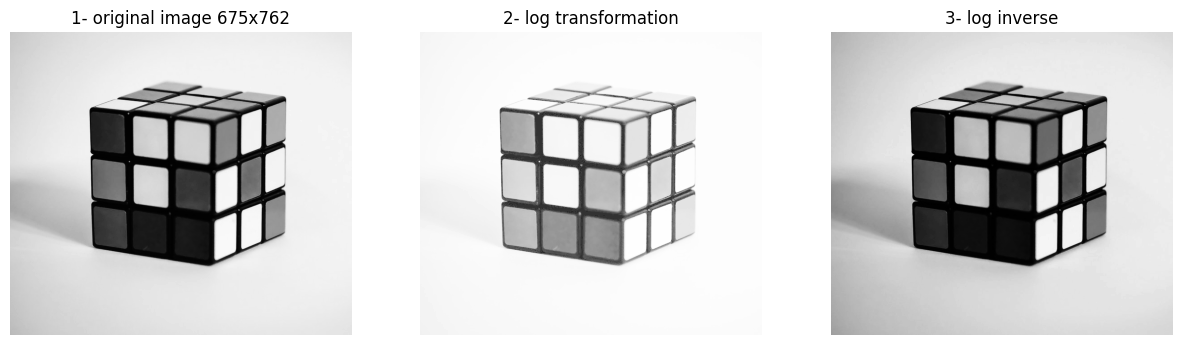

In [5]:
log_filtered_image = log_filter(original_image)
inv_filtered_image = inverse_log_filter(original_image)

plot_images([[original_image, '1- original image 675x762'],
            [log_filtered_image, "2- log transformation"], [inv_filtered_image, '3- log inverse']])

#**Power Law (Gamma) Transformation**

s = c r^gamma


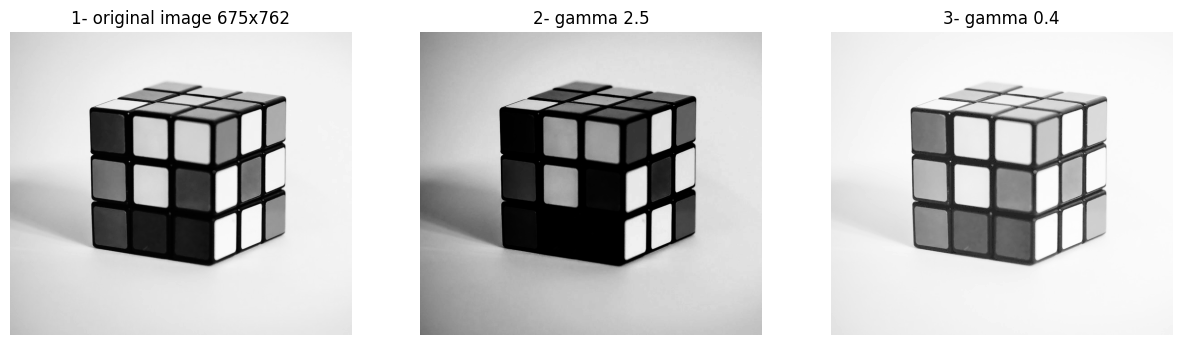

In [6]:
c, gamma = 255, 2.5

transformed_image1 = c * ((original_image/255)**gamma)

gamma = 0.4

transformed_image = c * ((original_image/255)**gamma)

plot_images([[original_image, '1- original image 675x762'],
             [transformed_image1, "2- gamma 2.5"],
            [transformed_image, "3- gamma 0.4"]])

#**Histogram Equalization**


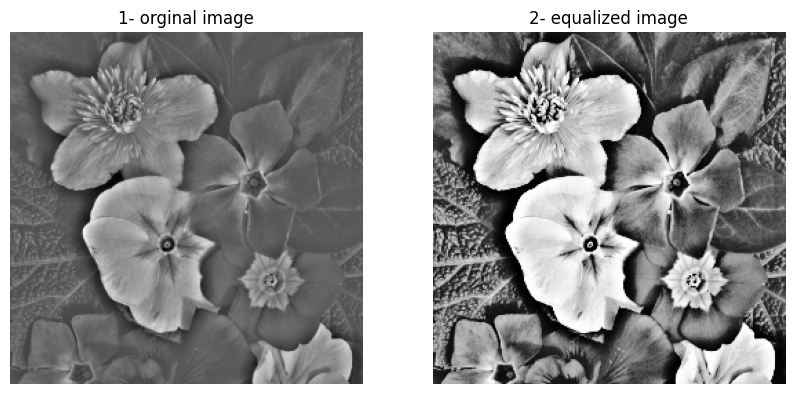

In [7]:
def hist_equal(image, L=256):
    pixels, nk = np.unique(image, return_counts=True)
    m, n = image.shape
    mn = m*n
    pr_rk = []
    for n in nk:
        pr_rk.append(n/mn)
    cdf = []
    temp = 0
    for i, val in enumerate(pr_rk):
        temp = temp + val
        cdf.append(temp)
    summation = dict(zip(pixels, cdf))
    equalized_image = np.zeros_like(image)
    for (h, w), x in np.ndenumerate(image):
        equalized_image[h][w] = np.floor((L-1)*summation[x])
    return equalized_image


dark_image = cv2.imread('hist2.png', cv2.IMREAD_GRAYSCALE)

plot_images([[dark_image, "1- orginal image"],
            [hist_equal(dark_image), '2- equalized image']])

#**Histogram of original and Enhanced Image**


Text(0.5, 1.0, '2- the custom enhanced image histogram')

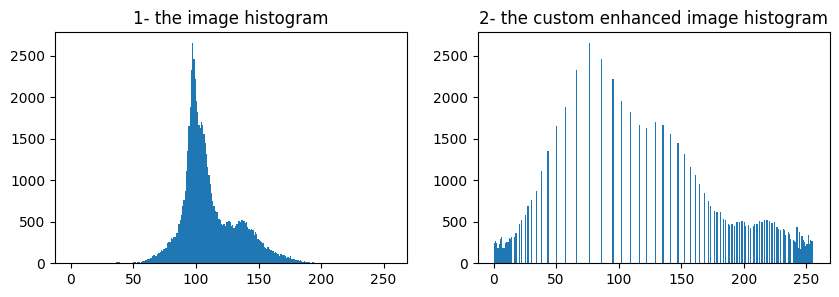

In [8]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.hist(dark_image.ravel(), 256, [0, 256])
plt.title('1- the image histogram')

plt.subplot(1, 2, 2)
plt.hist(hist_equal(dark_image).ravel(), 256, [0, 256])
plt.title('2- the custom enhanced image histogram')

#**Box Filtering**


In [9]:
def box_filter(image, m):
    pad_rows = m//2

    padded_image = np.pad(image, pad_width=pad_rows,
                          mode='constant', constant_values=0)
    blur_image = np.zeros_like(image)
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            window = padded_image[x: x + m, y: y + m]
            value = np.sum(window)
            blur_image[x, y] = int(value/(m*m))
    return blur_image

**Box Filtering with kernal 3x3, 11x11 21x21**


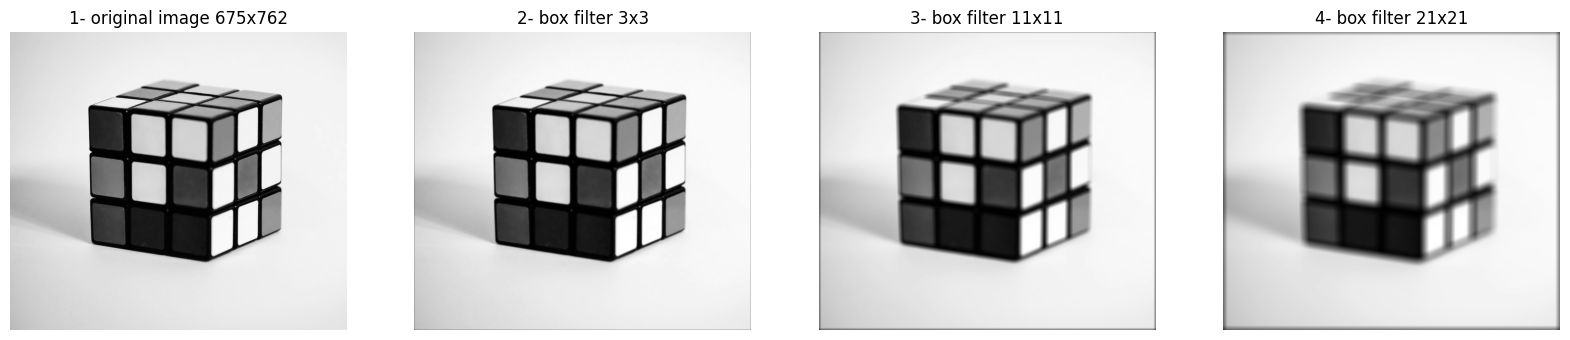

In [10]:
plot_images([[original_image, '1- original image 675x762'],
             [box_filter(original_image, 3), "2- box filter 3x3"],
             [box_filter(original_image, 11), "3- box filter 11x11"],
             [box_filter(original_image, 21), "4- box filter 21x21"],])

#**Lowpass Gaussian Filtering**:


In [11]:
def convolution(image, kernel, average=False):
    image_row, image_col = image.shape
    kernel_row, kernel_col = kernel.shape

    output = np.zeros(image.shape)

    pad_height = (kernel_row - 1) // 2
    pad_width = (kernel_col - 1) // 2

    padded_image = np.zeros(
        (image_row + (2 * pad_height), image_col + (2 * pad_width)))
    padded_image[pad_height:padded_image.shape[0] - pad_height,
                 pad_width:padded_image.shape[1] - pad_width] = image

    for row in range(image_row):
        for col in range(image_col):
            output[row, col] = np.sum(
                kernel * padded_image[row:row + kernel_row, col:col + kernel_col])
            if average:
                output[row, col] /= kernel.shape[0] * kernel.shape[1]

    return output

**Guassian Kernel**


In [12]:
def dnorm(x, mu, sd):
    return 1 / (np.sqrt(2 * np.pi) * sd) * np.e ** (-np.power((x - mu) / sd, 2) / 2)


def gaussian_kernel(size, sigma=1):
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    for i in range(size):
        kernel_1D[i] = dnorm(kernel_1D[i], 0, sigma)
    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)

    kernel_2D *= 1.0 / kernel_2D.max()

    return kernel_2D

**Gaussian Blurr using kernel 21 x 21 with sigma 3.5**


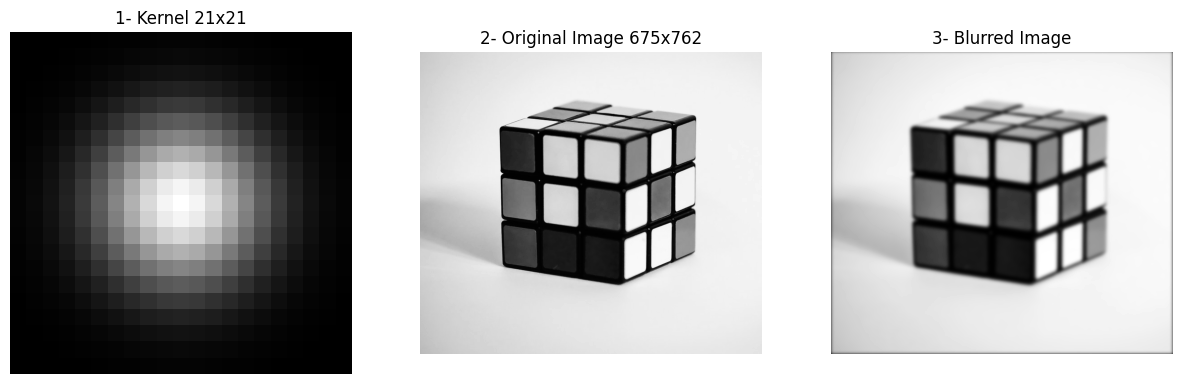

In [13]:
kernel_size = 21
sigma = 3.5

kernel = gaussian_kernel(kernel_size, sigma=sigma)
blur_image = convolution(original_image, kernel, average=True,)
plot_images([[kernel, "1- Kernel 21x21"],
             [original_image, '2- Original Image 675x762'],
             [blur_image, '3- Blurred Image']])

**Blur Image with Gaussain filter size 43 x 43 and simga = 7**


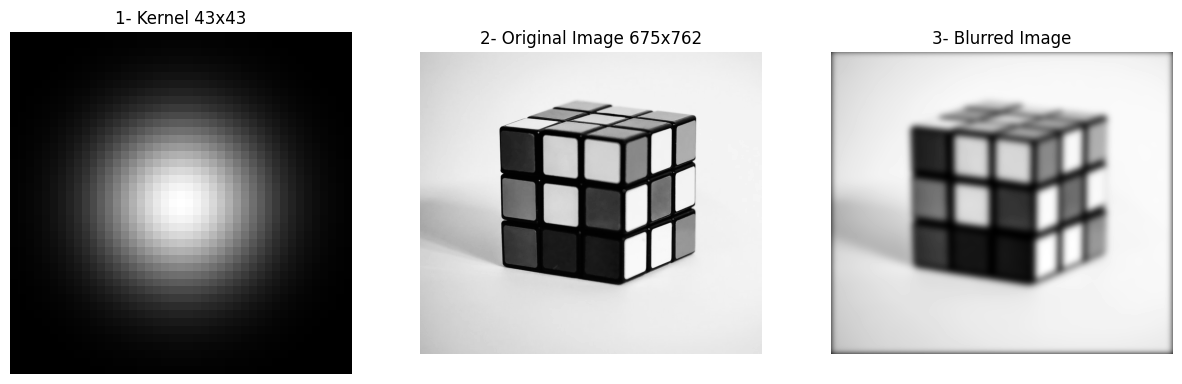

In [14]:
kernel_size = 43
sigma = 7

kernel = gaussian_kernel(kernel_size, sigma=sigma)
blur_image = convolution(original_image, kernel, average=True,)
plot_images([[kernel, "1- Kernel 43x43"],
             [original_image, '2- Original Image 675x762'],
             [blur_image, '3- Blurred Image']])

**Blur Image with Gaussian kernel size 85 x 85 with sigma 7**


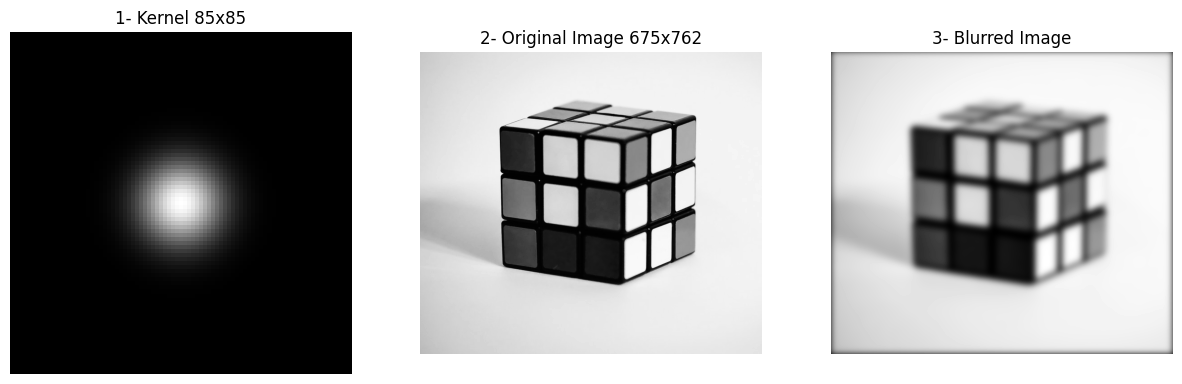

In [15]:
kernel_size = 85
sigma = 7

kernel = gaussian_kernel(kernel_size, sigma=sigma)
blur_image = convolution(original_image, kernel, average=True,)
plot_images([[kernel, "1- Kernel 85x85"],
             [original_image, '2- Original Image 675x762'],
             [blur_image, '3- Blurred Image']])

### Order Statistics (Non-Linear) Filters

Median Filter


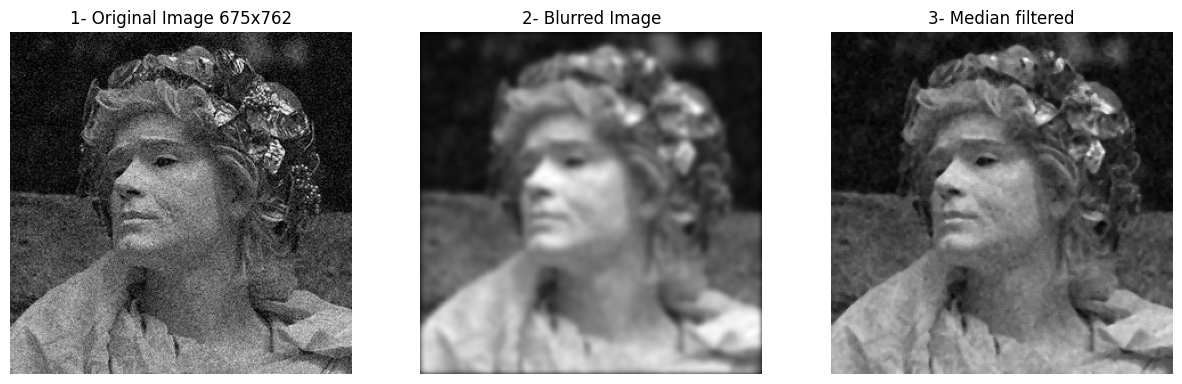

In [16]:
def median_filter(image, kernel_size):
    image_rows, image_cols = image.shape
    pad_rows = (kernel_size-1) // 2
    pad_cols = (kernel_size-1) // 2
    padded_image = np.pad(image, ((pad_rows, pad_rows),
                          (pad_cols, pad_cols)), mode='reflect')
    output = np.zeros_like(image)

    for row in range(image_rows):
        for col in range(image_cols):
            neighbours = padded_image[row: row +
                                      kernel_size, col: col + kernel_size]
            median_val = np.median(np.ravel(neighbours))
            output[row, col] = median_val

    return output


noised_image = cv2.imread('noise.jpg', cv2.IMREAD_GRAYSCALE)

blur_image = convolution(
    noised_image, gaussian_kernel(21, sigma=2.5), average=True,)

plot_images([[noised_image, '1- Original Image 675x762'],
             [blur_image, '2- Blurred Image'],
             [median_filter(noised_image, 4), '3- Median filtered']])

#**Sharpening (Highpass) Spatial Filters**


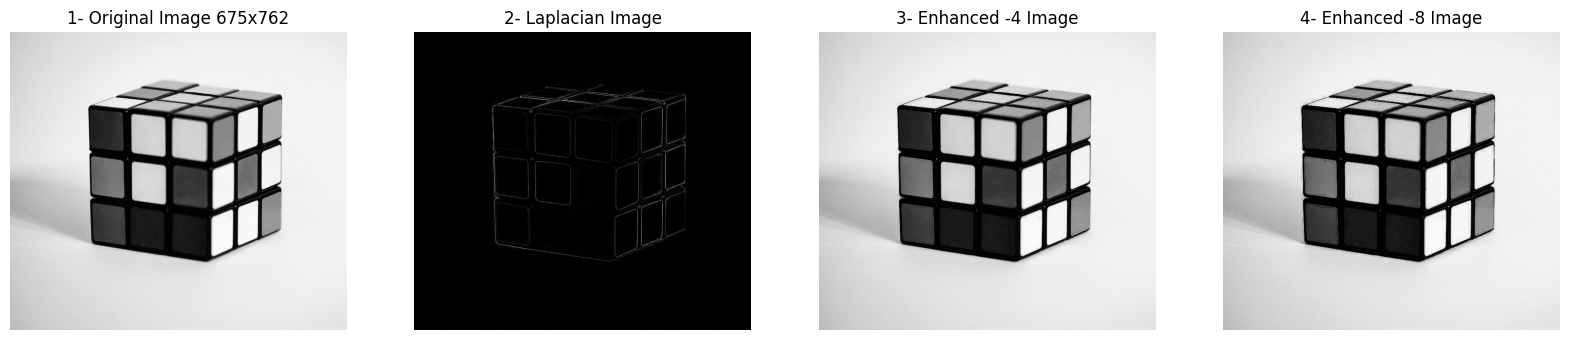

In [17]:

def laplacian_sharp(image, kernel):
    image_rows, image_cols = image.shape
    kernel_rows, kernel_cols = kernel.shape

    pad_rows = (kernel_rows - 1) // 2
    pad_cols = (kernel_cols - 1) // 2

    padded_image = np.pad(image, ((pad_rows, pad_rows),
                          (pad_cols, pad_cols)), mode='reflect')

    output_image = np.zeros_like(image)
    for row in range(image_rows):
        for col in range(image_cols):
            val = np.sum(
                kernel * padded_image[row: row + kernel_rows, col: col + kernel_cols])
            output_image[row, col] = 0 if val < 0 else val

    return output_image


laplacian_kernel1 = np.array([[0, 1, 0],
                              [1, -4, 1],
                              [0, 1, 0]])
laplacian_kernel2 = np.array([[1, 1, 1],
                              [1, -8, 1],
                              [1, 1, 1]])
c = -1
result1 = laplacian_sharp(original_image, laplacian_kernel1)
result2 = laplacian_sharp(original_image, laplacian_kernel2)
enhanced_image1 = np.where(
    (original_image + (c * result1) < 0), 0, original_image + (c * result1))
enhanced_image2 = np.where(
    (original_image + (c * result2) < 0), 0, original_image + (c * result2))

plot_images([[original_image, '1- Original Image 675x762'],
             [result1, '2- Laplacian Image'],
             [enhanced_image1, '3- Enhanced -4 Image'],
             [enhanced_image2, '4- Enhanced -8 Image']])

**UNSHARP MASKING AND HIGHBOOST FILTERING**


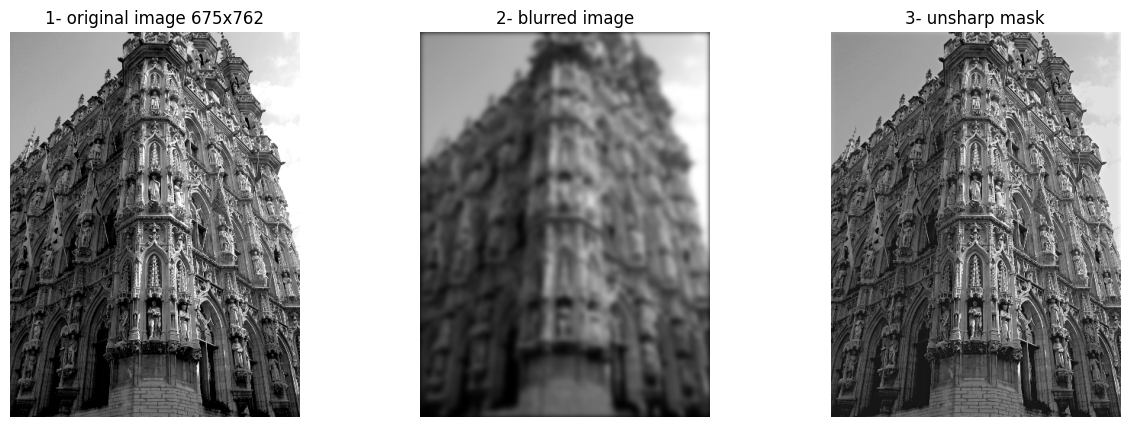

In [18]:
kernel = gaussian_kernel(21, sigma=3.5)

nusharp_image = cv2.imread('blog9_fig1.png', cv2.IMREAD_GRAYSCALE)
nusharp_image = nusharp_image.astype(np.float64)

blurred_image = convolution(nusharp_image, kernel, average=True,)

unsharp_mask = nusharp_image - blurred_image
unsharp_mask1 = unsharp_mask - np.min(unsharp_mask)
unsharp_mask1 = 255 * (unsharp_mask1/np.max(unsharp_mask1))
k = 1
sharp_image1 = nusharp_image + (k * unsharp_mask)
k = 4.5
sharp_image2 = nusharp_image + (k * unsharp_mask)
plot_images([[nusharp_image, '1- original image 675x762'],
             [blurred_image, '2- blurred image'],
             [unsharp_mask1, '3- unsharp mask']])

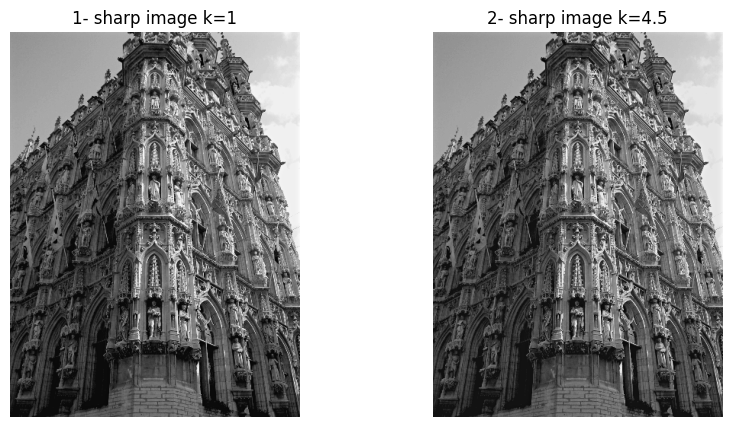

In [19]:
plot_images([[sharp_image1, '1- sharp image k=1'],
            [sharp_image2, '2- sharp image k=4.5']])

**USING FIRST-ORDER DERIVATIVES FOR IMAGE SHARPENING—THE
GRADIENT**


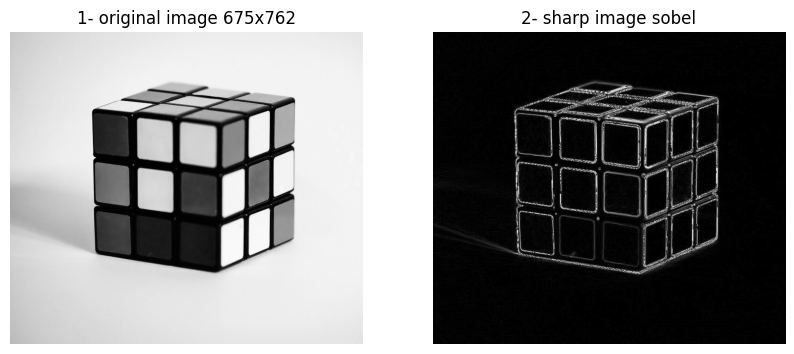

In [20]:
def gradient_filter(image, kernel_x, kernel_y):
    img_rows, img_cols = image.shape
    k_x_rows, k_x_cols = kernel_x.shape
    k_y_rows, k_y_cols = kernel_y.shape
    pad_rows = (k_x_rows - 1) // 2
    pad_cols = (k_x_cols - 1) // 2
    padded_image = np.pad(image, ((pad_rows, pad_rows),
                          (pad_cols, pad_cols)), mode='reflect')
    output_image = np.zeros_like(image)

    for row in range(img_rows):
        for col in range(img_cols):
            gx = np.sum(
                kernel_x * padded_image[row: row + k_x_rows, col: col + k_x_cols])
            gy = np.sum(
                kernel_y * padded_image[row: row + k_y_rows, col: col + k_y_cols])
            output_image[row, col] = np.sqrt(np.power(gx, 2)+np.power(gy, 2))
    return output_image


gradient_x_kernel = np.array([[-1, -2, -1],
                              [0, 0, 0],
                              [1, 2, 1]])
gradient_y_kernel = np.array([[-1, 0, 1],
                              [-2, 0, 2],
                              [-1, 0, 1]])
sharp_image = gradient_filter(
    original_image, gradient_x_kernel, gradient_y_kernel)

plot_images([[original_image, '1- original image 675x762'],
            [sharp_image, '2- sharp image sobel']])

**Ideal low pass**


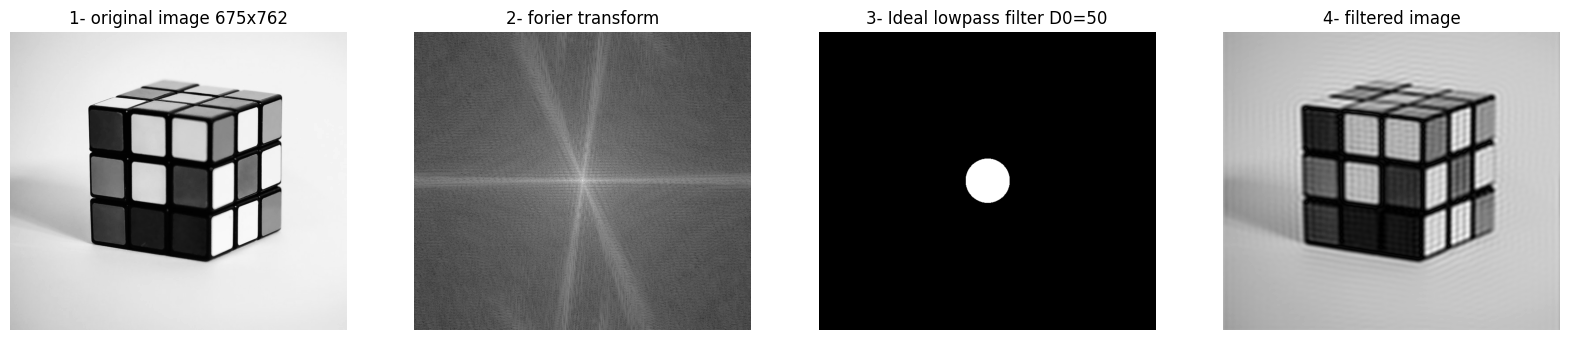

In [21]:
M, N = original_image.shape

F = np.fft.fft2(original_image)

Fshift = np.fft.fftshift(F)

H = np.zeros((M, N), dtype=np.float32)
D0 = 50
for u in range(M):
    for v in range(N):
        D = np.sqrt((u-M/2)**2 + (v-N/2)**2)
        if D <= D0:
            H[u, v] = 1
        else:
            H[u, v] = 0

Gshift = Fshift * H

G = np.fft.ifftshift(Gshift)

plot_images([[original_image, '1- original image 675x762'],
             [np.log1p(np.abs(Fshift)), "2- forier transform"],
             [H, '3- Ideal lowpass filter D0=50'],
             [np.abs(np.fft.ifft2(G)), '4- filtered image']])

**Ideal highpass**


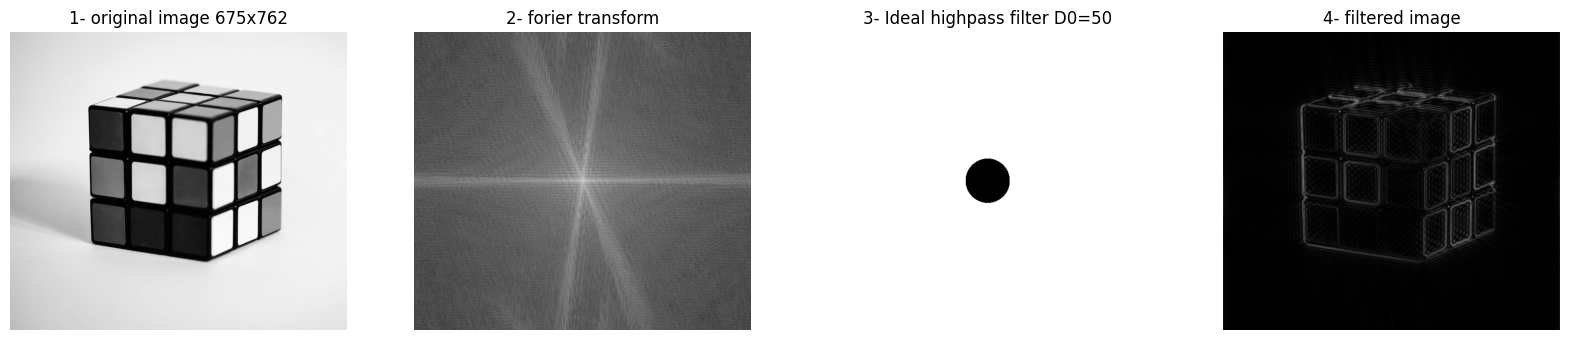

In [22]:
H_high = 1 - H

Gshift_high = Fshift * H_high

G_high = np.fft.ifftshift(Gshift_high)

plot_images([[original_image, '1- original image 675x762'],
             [np.log1p(np.abs(Fshift)), "2- forier transform"],
             [H_high, '3- Ideal highpass filter D0=50'],
             [np.abs(np.fft.ifft2(G_high)), '4- filtered image']])

**guassian lowpass**


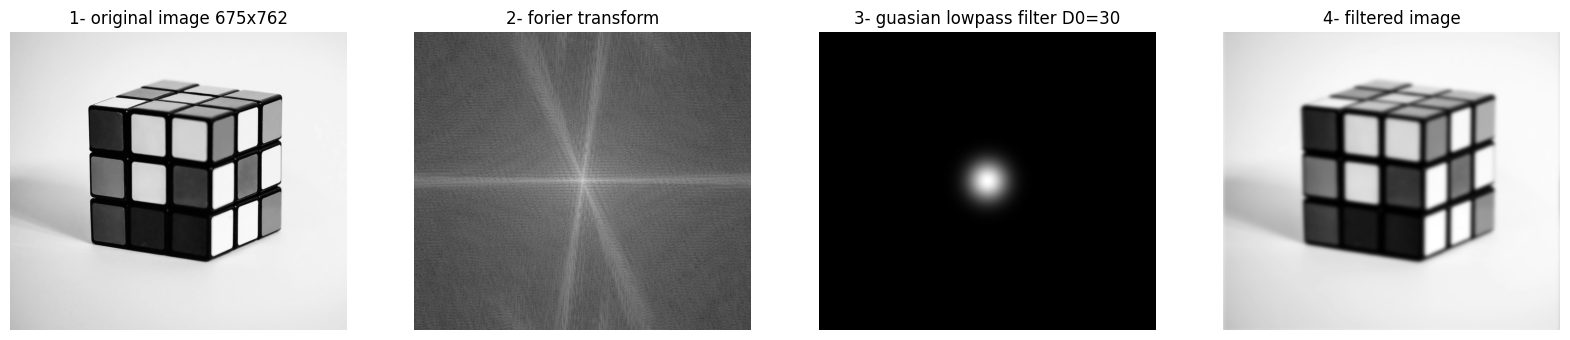

In [23]:
M, N = original_image.shape
H = np.zeros((M, N), dtype=np.float32)
D0 = 30
for u in range(M):
    for v in range(N):
        D = np.sqrt((u-M/2)**2 + (v-N/2)**2)
        H[u, v] = np.exp(-D**2/(2*D0*D0))

Gshift = Fshift * H
G = np.fft.ifftshift(Gshift)
g = np.abs(np.fft.ifft2(G))

plot_images([[original_image, '1- original image 675x762'],
             [np.log1p(np.abs(Fshift)), "2- forier transform"],
             [H, '3- guasian lowpass filter D0=30'],
             [np.abs(np.fft.ifft2(G)), '4- filtered image']])

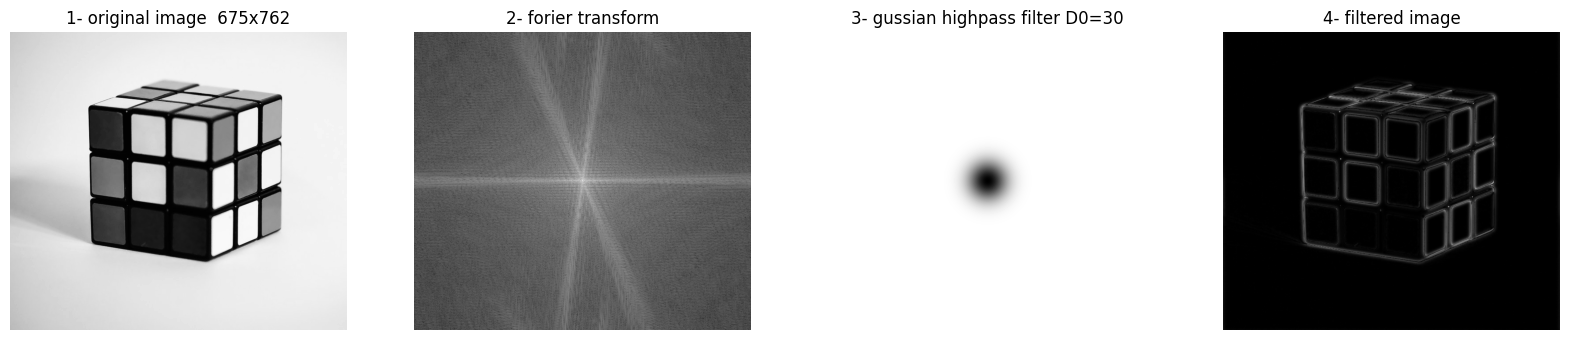

In [24]:
HPF = 1 - H

Gshift = Fshift * HPF
G = np.fft.ifftshift(Gshift)
g = np.abs(np.fft.ifft2(G))


plot_images([[original_image, '1- original image  675x762'],
             [np.log1p(np.abs(Fshift)), "2- forier transform"],
             [HPF, '3- gussian highpass filter D0=30'],
             [g, '4- filtered image']])

**butterworth**


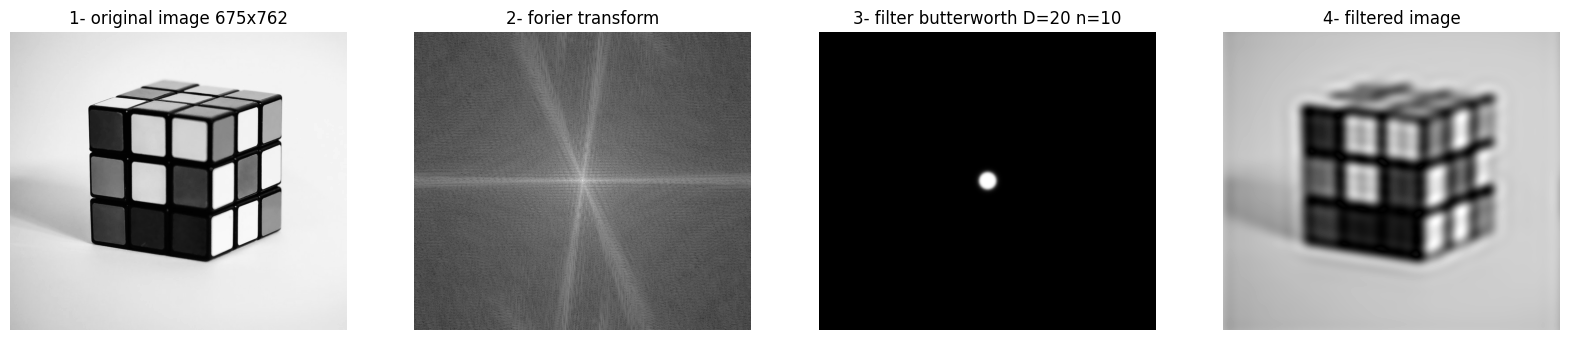

In [25]:
M, N = original_image.shape
H = np.zeros((M, N), dtype=np.float32)
D0 = 20
n = 10
for u in range(M):
    for v in range(N):
        D = np.sqrt((u-M/2)**2 + (v-N/2)**2)
        H[u, v] = 1 / (1 + (D/D0)**n)

Gshift = Fshift * H
G = np.fft.ifftshift(Gshift)
g = np.abs(np.fft.ifft2(G))


plot_images([[original_image, '1- original image 675x762'],
             [np.log1p(np.abs(Fshift)), "2- forier transform"],
             [H, '3- filter butterworth D=20 n=10'],
             [g, '4- filtered image']])

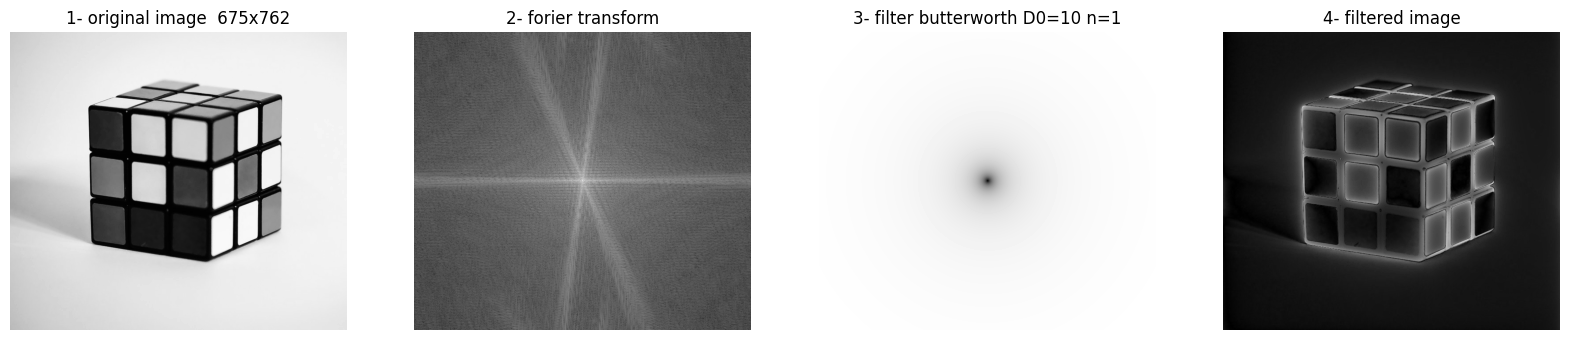

In [26]:
HPF = np.zeros((M, N), dtype=np.float32)
D0 = 10
n = 1
for u in range(M):
    for v in range(N):
        D = np.sqrt((u-M/2)**2 + (v-N/2)**2)
        HPF[u, v] = 1 / (1 + (D0/D)**n)

Gshift = Fshift * HPF
G = np.fft.ifftshift(Gshift)
g = np.abs(np.fft.ifft2(G))

plot_images([[original_image, '1- original image  675x762'],
             [np.log1p(np.abs(Fshift)), "2- forier transform"],
             [HPF, '3- filter butterworth D0=10 n=1'],
             [g, '4- filtered image']])